<center> <h1>APRENDIZAJE POR REFUERZO</h1> </center>
<center> <h2>Práctica 1: SARSA y Q-LEARNING</h2> </center>
<center> <h4>Luis Sánchez Polo</h4> </center>
<center> <h4>María José Damián Diez</h4> </center>
<center> <h5>7 de mayo de 2023</h5> </center>





# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [2]:
import numpy as np
import random
import math

Funciones auxiliares para visualizar información:

In [3]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0: 
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X " 
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      color = "\033[0m"
      if world.map[(i, j)] == -1:
        p += color + " X "
      elif world.map[(i, j)] == 1:
        p += color + " F "
      else:
        if world.map[(i, j)] == 2:
            color = "\033[;36;47m"
        if policy[i][j] == 0:
            p += color + " ^ "
        elif policy[i][j] == 1:
            p += color + " v "
        elif policy[i][j] == 2:
            p += color + " < "
        else:
            p += color + " > "
    p += "\n"
  print(p)

# Clase *World*: 

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo

Por ejemplo: 

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

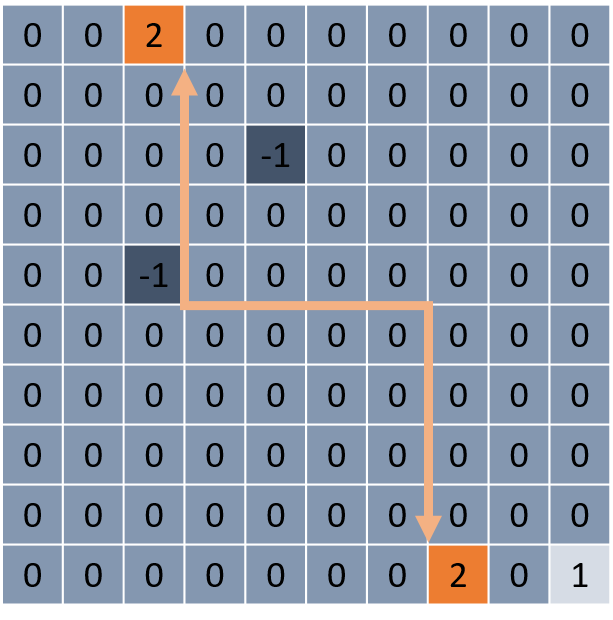

In [4]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

Prueba de la clase *World*:

In [5]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*. 

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos. 

In [6]:
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -1 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = 0 # ** Prueba varios valores ** 
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1: 
      nextState = state                            
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1: 
      nextState = self.state     
    else: 
      self.state = nextState                                 
    reward = self.reward(nextState)
    return self.state, reward  

Prueba de la clase *Agent*:

In [7]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([0, 1]), 0)
(array([9, 7]), 0)
(array([9, 8]), 0)
(array([9, 9]), 1)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos: 

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [8]:
if __name__ == "__main__":
  
  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]          
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.

In [9]:
# Funciones auxiliares:

def choose_action(Q, S, actions, epsilon):
  ''' Escoge una acción, ya sea por exploración o explotación para los estados '''

  if np.random.rand() < epsilon:
    action = np.random.choice(len(actions)) # Acción por exploración
  else:
    action = np.argmax(Q[S[0], S[1], :]) # Acción por explotación
  return action 


def random_state(world):
  '''Escoge la posición inicial del estado de forma aleatoria considerando el tamaño del mundo'''

  # Obtener el tamaño del mundo
  size = world.size
  
  # Elegir una posición aleatoria que no sea un obstáculo
  while True:
    x = random.randint(0, size[0]-1)
    y = random.randint(0, size[1]-1)
    if world.map[(x, y)] not in [-1, 1]:
        break
  
  # Devolver la posición como estado
  state = [x,y]
  return state

In [10]:
# Resolución: Código de SARSA

def SARSA(world, actions, S, alpha=0.5, gamma=0.9, epsilon=0.1, max_iterations=10000, contador_max=100):
  
  # Crear agente
  agent = Agent(world, S)

  # 1. Inicializar Q
  num_actions = len(actions)
  Q = np.zeros((world.size[0], world.size[1], num_actions))

  # 2. Bucle hasta que converja o cumpla el máximo de iteraciones 
  episode = 0
  while episode < max_iterations:
    # 3. Inicializar S
    if episode < max_iterations/4:
      state = random_state(world)
    else:
      state = S
    
    # 4. Elegir A en S siguiendo la política derivada de Q(S,A)    
    reward_sum = 0
    contador = 0

    # 5. Bucle hasta S sea terminal
    while contador < contador_max:

      idx_action = choose_action(Q, S, actions, epsilon)
      action = actions[idx_action]

      # 6. Tomar la acción en S y observar reward next_S
      next_state, reward = agent.checkAction(state, action) #cambiar
      #print(state, next_state, reward)

      #7. Elegir nueva acción
      next_idx_action = choose_action(Q, next_state, actions, epsilon)
      
      # 8. Actualizar Q
      Q[state[0], state[1], idx_action] += alpha * (reward + gamma * Q[next_state[0], next_state[1], next_idx_action] - Q[state[0], state[1], idx_action])

      # 9. Actualizar estado y acción
      state = next_state
      action = actions[next_idx_action]
      reward_sum += reward

      # Comprobar si se ha llegado a un estado terminal o a un obstáculo
      if world.map[(state[0], state[1])] in [-1, 1]:
        break
      
      contador +=1
          
      #Siguiente episodio
    episode += 1

  # Política aprendida
  policy = np.argmax(Q, axis=2)
  print('Mundo')
  printMap(world)
  print('Política')
  printPolicy(world,policy)
  print(policy)
  
  return print("\nEpisodios: {}".format(episode))

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.


In [11]:
# Resolución: Código de Q-Learning
def Q_Learning(world, actions, S, alpha=0.5, gamma=1, epsilon=0.1, max_iterations=1000, contador_max=100):
    
  # Crear agente
  agent = Agent(world, S)

  # 1. Inicializar Q
  num_actions = len(actions)
  Q = np.zeros((world.size[0], world.size[1], num_actions))

  # 2. Bucle hasta que converja o cumpla el máximo de iteraciones 
  episode = 0
  while episode < max_iterations:
    # 3. Inicializar S
    if episode < max_iterations/3:
      state = random_state(world)
    else:
      state = S
    reward_sum = 0
    contador = 0
    # 4. Bucle hasta que S sea terminal
    while contador < contador_max:
      # 5. Elegir A en S siguiendo la política derivada de Q(S,A) 
      idx_action = choose_action(Q, S, actions, epsilon)
      action = actions[idx_action]
      
      # 6.Tomar la acción en S y observar reward next_S
      next_state, reward = agent.checkAction(state, action)

      # 7. Actualizar Q
      Q[state[0], state[1], idx_action] += alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], idx_action])

      # 8. Actualizar estado 
      state = next_state
      reward_sum += reward

      # Comprobar si se ha llegado a un estado terminal o a un obstáculo
      if world.map[(state[0], state[1])] in [1, -1]:
          break

      contador +=1 
      
    #Siguiente episodio
    episode += 1

  # Política aprendida
  policy = np.argmax(Q, axis=2)

  print('Mundo')
  printMap(world)
  print('Política')
  printPolicy(world,policy)
  print(policy)
  
  return print("\nEpisodios: {}".format(episode))

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 3:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba.

1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?

Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.

3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

4.   Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje 
. ¿Qué valores dan mejores resultados?

In [12]:
#Definimos estado inicial y actiones:
S = (0, 0)
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

A continuación, compararemos las políticas de nuestros dos algoritmos en distintos mundos y parámetros:

### Mundo 1 pequeño



In [ ]:
policy_sarsa_1 = SARSA(w1p, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=5000, contador_max=500)

Mundo
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

Política
 v  X  >  >  v 
 v  X  v  X  v 
 v  X  ^  X  v 
 <  X  v  X  v 
 <  <  v  X  F 

[[1 0 3 3 1]
 [1 0 1 0 1]
 [1 0 0 0 1]
 [2 0 1 0 1]
 [2 2 1 0 0]]

Episodios: 5000


In [ ]:
policy_q_learning_1 = Q_Learning(w1p, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=5000, contador_max=500)

Mundo
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

Política
 v  X  >  >  v 
 v  X  ^  X  v 
 v  X  ^  X  v 
 v  X  ^  X  v 
 >  >  ^  X  F 

[[1 0 3 3 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [3 3 0 0 0]]

Episodios: 5000


* Podemos ver que utilizando los parámetros *alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=5000, contador_max=500*, solo el algoritmo **Q-Learning** logra encontrar el camino óptimo. A continuación, probaremos el algoritmo SARSA aumento a 800 el contador del segundo bucle, para ver si, teniendo más "pasos", logramos encontrar el camino óptimo.

In [ ]:
policy_sarsa_1b = SARSA(w1p, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=5000, contador_max=800)

Mundo
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

Política
 v  X  >  >  v 
 v  X  ^  X  v 
 v  X  ^  X  v 
 v  X  ^  X  v 
 >  >  ^  X  F 

[[1 0 3 3 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [3 3 0 0 0]]

Episodios: 5000


**Análisis Mundo 1 pequeño:** 

Con el aumento del parámetro *contador_max* en el algoritmo **SARSA** el agente ha encontrado el camino optimo. 

Podemos concluir que para el **mundo 1 pequeño**, el algoritmo que mejor resultados da es **Q-Learning**, ya que logra encuentra en menos iteraciones el camino óptimo. La principal diferencia entre los dos algoritmos es la actualización de Q, por tanto, probablemente este debe ser el motivo de que Q-Learning encuentra más rápido la solución en este tipo de mundo.

### Mundo 1 mediano

In [ ]:
policy_sarsa_1m = SARSA(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=20000, contador_max=1000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 v  X  >  <  <  X  >  >  v 
 v  X  ^  X  ^  X  v  X  v 
 v  X  ^  X  v  X  v  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  ^  X  v  X  > 
 <  X  ^  X  ^  X  v  X  v 
 v  X  v  X  ^  X  ^  X  v 
 <  X  v  X  ^  X  v  X  v 
 v  >  <  X  v  v  v  X  F 

[[1 0 3 2 2 0 3 3 1]
 [1 0 0 0 0 0 1 0 1]
 [1 0 0 0 1 0 1 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 0 0 1 0 3]
 [2 0 0 0 0 0 1 0 1]
 [1 0 1 0 0 0 0 0 1]
 [2 0 1 0 0 0 1 0 1]
 [1 3 2 0 1 1 1 0 0]]

Episodios: 20000


In [ ]:
policy_q_learning_1m = Q_Learning(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=20000, contador_max=1000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 ^  X  ^  ^  ^  X  >  >  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  v  ^  X  ^  v  ^  X  F 

[[0 0 0 0 0 0 3 3 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 1 0 0 0]]

Episodios: 20000


* Podemos ver que para los parámetros *alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=20000, contador_max=1000* tanto SARSA como Q-Learning **no logran encontrar el valor óptimo**. A continuación, probaremos aumentar el número de iteraciones.

In [ ]:
policy_sarsa_1m_2 = SARSA(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=30000, contador_max=3000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 v  X  ^  <  <  X  >  >  v 
 <  X  ^  X  ^  X  ^  X  v 
 <  X  ^  X  ^  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 <  X  ^  X  v  X  ^  X  > 
 v  X  ^  X  ^  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 <  X  v  X  v  X  ^  X  v 
 <  <  v  X  >  >  ^  X  F 

[[1 0 0 2 2 0 3 3 1]
 [2 0 0 0 0 0 0 0 1]
 [2 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [2 0 0 0 1 0 0 0 3]
 [1 0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [2 0 1 0 1 0 0 0 1]
 [2 2 1 0 3 3 0 0 0]]

Episodios: 30000


In [ ]:
policy_q_learning_1m_2 = Q_Learning(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=30000, contador_max=3000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 ^  X  ^  ^  ^  X  >  >  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  v  X  ^  X  v 
 ^  v  ^  X  >  >  ^  X  F 

[[0 0 0 0 0 0 3 3 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 1]
 [0 1 0 0 3 3 0 0 0]]

Episodios: 30000


* Podemos ver, principalmente en el algoritmo Q-Learning, que la política obtenida no cambia mucho al aumentar las iteraciones en ambos bucles, por lo que, probaremos si cambiando el valor de $\epsilon$, ejemplo a 0.4, para que tenga opción de explorar más, nos da un mejor resultado.

In [ ]:
policy_sarsa_1m_3 = SARSA(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.4, max_iterations=20000, contador_max=1000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 v  X  >  >  <  X  ^  >  v 
 ^  X  ^  X  v  X  ^  X  v 
 <  X  ^  X  ^  X  ^  X  v 
 v  X  ^  X  ^  X  ^  X  > 
 <  X  ^  X  ^  X  v  X  > 
 ^  X  ^  X  v  X  v  X  v 
 ^  X  v  X  ^  X  ^  X  > 
 <  X  v  X  v  X  v  X  v 
 v  <  ^  X  >  v  v  X  F 

[[1 0 3 3 2 0 0 3 1]
 [0 0 0 0 1 0 0 0 1]
 [2 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 3]
 [2 0 0 0 0 0 1 0 3]
 [0 0 0 0 1 0 1 0 1]
 [0 0 1 0 0 0 0 0 3]
 [2 0 1 0 1 0 1 0 1]
 [1 2 0 0 3 1 1 0 0]]

Episodios: 20000


In [ ]:
policy_q_learning_1m_3 = Q_Learning(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.4, max_iterations=20000, contador_max=1000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 v  X  >  >  v  X  >  >  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 >  >  ^  X  >  >  ^  X  F 

[[1 0 3 3 1 0 3 3 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [3 3 0 0 3 3 0 0 0]]

Episodios: 20000


* Con los parámetros utilizados inicialmente para el mundo 1 mediano, cambiando ahora el $\epsilon$ a 0.4, hemos obtenido que el algoritmo Q-Learning encuentra el camino optimo. Ahora probaremos dejando el $\epsilon$ en 0.4, aumentar el *contador_max* en el algoritmo SARSA, para ver si logramos que el agente encuentre el camino optimo.  

In [ ]:
policy_sarsa_1m_4 = SARSA(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.4, max_iterations=30000, contador_max=4500)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 <  X  v  <  ^  X  >  >  v 
 v  X  ^  X  v  X  ^  X  > 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  ^  X  ^  X  v 
 <  X  ^  X  ^  X  ^  X  v 
 ^  X  v  X  ^  X  ^  X  v 
 v  X  ^  X  v  X  ^  X  v 
 v  X  ^  X  v  X  v  X  v 
 v  <  <  X  v  v  v  X  F 

[[2 0 1 2 0 0 3 3 1]
 [1 0 0 0 1 0 0 0 3]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 1]
 [2 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0 1]
 [1 0 0 0 1 0 1 0 1]
 [1 2 2 0 1 1 1 0 0]]

Episodios: 30000


* Hemos probado varios valores aumentando los parámetros de iteración y no hemos conseguido que el agente encuentre la solución óptima. Ahora intentaremos bajando el épsilon a 0.01.

In [ ]:
policy_sarsa_1m_5 = SARSA(w1m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.01, max_iterations=20000, contador_max=1000)

Mundo
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

Política
 v  X  ^  <  <  X  ^  ^  v 
 <  X  ^  X  ^  X  ^  X  v 
 v  X  ^  X  ^  X  ^  X  v 
 <  X  ^  X  ^  X  ^  X  v 
 <  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 ^  X  ^  X  ^  X  ^  X  v 
 <  <  ^  X  ^  v  v  X  F 

[[1 0 0 2 2 0 0 0 1]
 [2 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1]
 [2 0 0 0 0 0 0 0 1]
 [2 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1]
 [2 2 0 0 0 1 1 0 0]]

Episodios: 20000


* A simple vista, podemos ver que utilizar un épsilon pequeño, para que explote más, no es recomendable en este tipo de mundos con laberintos.

**Análisis Mundo 1 mediano:** 

Podemos concluir que para el mundo 1 mediado, que es un laberinto con camino único, el algoritmo que mejor funciona para que el agente encuentre el camino optimo es **Q-Learning**, pero utilizando un épsilon más exploratorio, es este caso hemos probado con un 40%.

### Mundo 2 pequeño

In [17]:
policy_sarsa_2p = SARSA(w2p, actions, S, alpha=0.5, gamma=0.9, epsilon=0.1, max_iterations=2000, contador_max=500)

Mundo
[ O  O  O  O  O 
 O  O  O  O  O 
 T  O  O  X  O 
 O  O  X  X  O 
 O  O  T  O  F ]

Política
 v  v  v  v  v 
 v  >  >  >  v 
 v  <  <  X  v 
 ^  <  X  X  v 
 >  >  >  >  F 

[[1 1 1 1 1]
 [1 3 3 3 1]
 [1 2 2 0 1]
 [0 2 0 0 1]
 [3 3 3 3 0]]

Episodios: 2000


In [21]:
policy_q_learning_2p = Q_Learning(w2p, actions, S, alpha=0.5, gamma=0.9, epsilon=0.1, max_iterations=2000, contador_max=500)

Mundo
[ O  O  O  O  O 
 O  O  O  O  O 
 T  O  O  X  O 
 O  O  X  X  O 
 O  O  T  O  F ]

Política
 v  v  >  v  v 
 v  v  >  >  v 
 v  <  <  X  v 
 ^  v  X  X  v 
 >  >  >  >  F 

[[1 1 3 1 1]
 [1 1 3 3 1]
 [1 2 2 0 1]
 [0 1 0 0 1]
 [3 3 3 3 0]]

Episodios: 2000


- Aumentamos el valor de épsilon. Al ser un mundo con más caminos posibles que el mundo 1, favorecer la exploración debería ayudar a encontrar la solución óptima. Aumentamos el número de iteraciones también para compensar.

In [46]:
policy_sarsa_2p_2 = SARSA(w2p, actions, S, alpha=0.5, gamma=0.9, epsilon=0.3, max_iterations=2000, contador_max=500)

Mundo
[ O  O  O  O  O 
 O  O  O  O  O 
 T  O  O  X  O 
 O  O  X  X  O 
 O  O  T  O  F ]

Política
 v  <  >  v  v 
 v  <  <  >  v 
 v  <  ^  X  v 
 ^  <  X  X  v 
 ^  >  >  >  F 

[[1 2 3 1 1]
 [1 2 2 3 1]
 [1 2 0 0 1]
 [0 2 0 0 1]
 [0 3 3 3 0]]

Episodios: 2000


In [47]:
policy_q_learning_2p_2 = Q_Learning(w2p, actions, S, alpha=0.5, gamma=0.9, epsilon=0.3, max_iterations=2000, contador_max=500)

Mundo
[ O  O  O  O  O 
 O  O  O  O  O 
 T  O  O  X  O 
 O  O  X  X  O 
 O  O  T  O  F ]

Política
 v  v  >  v  v 
 v  v  >  >  v 
 >  <  <  X  v 
 ^  v  X  X  v 
 ^  >  >  >  F 

[[1 1 3 1 1]
 [1 1 3 3 1]
 [3 2 2 0 1]
 [0 1 0 0 1]
 [0 3 3 3 0]]

Episodios: 2000


**Análisis Mundo 2 pequeño:** 

Para este mundo, ambos algoritmos funcionan de una manera muy eficiente para un número pequeño de iteraciones, si bien el contador del segundo bucle se debe mantener relativamente alto para garanizar que explore los caminos. De nuevo, Q-learning funciona mejor que SARSA, pues en para el mismo número de pasos sí consigue encontrar la solución más cercana a la óptima.

### Mundo 2 mediano


In [48]:
policy_sarsa_2m = SARSA(w2m, actions, S, alpha=0.5, gamma=0.9, epsilon=0.1, max_iterations=10000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  X  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  T  O  O  O  O  O  O  O  O 
 O  O  O  O  O  X  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  X  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  T  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 v  >  >  >  >  v  v  >  v  v 
 v  X  X  >  >  >  >  v  v  v 
 >  v  <  v  v  >  >  v  v  v 
 >  ^  v  v  v  >  >  >  >  v 
 >  ^  <  v  v  X  v  X  v  v 
 ^  ^  X  >  v  v  >  v  v  v 
 ^  <  v  X  v  v  v  v  v  v 
 ^  X  v  X  >  v  v  v  v  v 
 ^  v  v  X  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  F 

[[1 3 3 3 3 1 1 3 1 1]
 [1 0 0 3 3 3 3 1 1 1]
 [3 1 2 1 1 3 3 1 1 1]
 [3 0 1 1 1 3 3 3 3 1]
 [3 0 2 1 1 0 1 0 1 1]
 [0 0 0 3 1 1 3 1 1 1]
 [0 2 1 0 1 1 1 1 1 1]
 [0 0 1 0 3 1 1 1 1 1]
 [0 1 1 0 3 3 3 3 1 1]
 [3 3 3 3 3 3 3 3 3 0]]

Episodios: 10000


In [54]:
policy_q_learning_2m_2 = Q_Learning(w2m, actions, S, alpha=0.5, gamma=0.9, epsilon=0.1, max_iterations=20000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  X  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  T  O  O  O  O  O  O  O  O 
 O  O  O  O  O  X  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  X  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  T  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 v  <  <  v  v  v  v  v  v  v 
 v  X  X  v  v  v  v  v  v  v 
 v  v  <  <  v  v  v  v  v  v 
 >  v  ^  >  v  >  v  >  v  v 
 ^  ^  <  v  v  X  v  X  v  v 
 ^  ^  X  >  v  v  v  v  v  v 
 ^  ^  v  X  v  v  v  v  v  v 
 ^  X  v  X  v  v  v  v  v  v 
 ^  v  v  X  v  v  v  v  v  v 
 >  >  >  >  >  >  >  >  >  F 

[[1 2 2 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 1 1 1]
 [1 1 2 2 1 1 1 1 1 1]
 [3 1 0 3 1 3 1 3 1 1]
 [0 0 2 1 1 0 1 0 1 1]
 [0 0 0 3 1 1 1 1 1 1]
 [0 0 1 0 1 1 1 1 1 1]
 [0 0 1 0 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 3 3 0]]

Episodios: 20000


**Análisis Mundo 2 mediano:** 

Para este mundo, el número de iteraciones requeridas por Q-learning para dar resultados aceptables es consirablemente superior al de SARSA. Es ambos casos, alcanzar la solución óptima exige un número de pasos muy elevado.

### Mundo 3 mediano 

* En principio probaremos con los mismos parámetros utilizado en el mundo 1 mediano, dependiendo de su resultado, intentaremos subir o bajar las iteraciones.

In [ ]:
policy_sarsa_3m = SARSA(w3m, actions, S,  alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=20000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  T  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  X  O  O  O  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 v  v  v  v  >  v  >  v  >  v 
 v  v  >  >  v  v  v  v  v  v 
 >  >  >  >  >  v  v  >  v  v 
 >  >  >  >  >  v  v  >  v  v 
 v  ^  X  >  v  v  v  >  v  v 
 v  v  <  X  >  >  >  >  v  v 
 v  v  X  v  v  v  v  X  v  v 
 v  v  X  v  v  v  >  >  v  v 
 >  v  X  >  >  v  v  X  v  v 
 >  >  >  >  >  >  >  >  >  F 

[[1 1 1 1 3 1 3 1 3 1]
 [1 1 3 3 1 1 1 1 1 1]
 [3 3 3 3 3 1 1 3 1 1]
 [3 3 3 3 3 1 1 3 1 1]
 [1 0 0 3 1 1 1 3 1 1]
 [1 1 2 0 3 3 3 3 1 1]
 [1 1 0 1 1 1 1 0 1 1]
 [1 1 0 1 1 1 3 3 1 1]
 [3 1 0 3 3 1 1 0 1 1]
 [3 3 3 3 3 3 3 3 3 0]]

Episodios: 20000


In [ ]:
policy_q_learning_3m = Q_Learning(w3m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=20000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  T  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  X  O  O  O  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 v  v  v  >  >  v  >  >  v  v 
 v  v  >  >  >  >  >  >  >  v 
 v  v  >  >  >  >  >  >  >  v 
 v  v  >  >  >  >  >  >  >  v 
 v  v  X  >  >  >  >  >  >  v 
 v  v  <  X  >  >  >  >  >  v 
 v  v  X  v  v  v  v  X  >  v 
 v  v  X  v  v  v  v  >  >  v 
 v  v  X  v  v  v  v  X  v  v 
 >  >  >  >  >  >  >  >  >  F 

[[1 1 1 3 3 1 3 3 1 1]
 [1 1 3 3 3 3 3 3 3 1]
 [1 1 3 3 3 3 3 3 3 1]
 [1 1 3 3 3 3 3 3 3 1]
 [1 1 0 3 3 3 3 3 3 1]
 [1 1 2 0 3 3 3 3 3 1]
 [1 1 0 1 1 1 1 0 3 1]
 [1 1 0 1 1 1 1 3 3 1]
 [1 1 0 1 1 1 1 0 1 1]
 [3 3 3 3 3 3 3 3 3 0]]

Episodios: 20000


* Podemos observar que ambos logran llegar a término si nos paramos en cualquier punto del mundo, pero con políticas distintas. Ahora intentaremos probar con menos iteraciones en ambos algoritmos a ver si llegan a término. 

In [ ]:
policy_sarsa_3m_2 = SARSA(w3m, actions, S,  alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=10000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  T  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  X  O  O  O  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  v  v 
 >  >  >  v  >  v  >  >  v  v 
 v  v  X  >  v  v  >  >  v  v 
 v  v  <  X  >  v  >  >  v  v 
 v  v  X  v  >  v  v  X  >  v 
 >  <  X  v  >  v  >  >  v  v 
 v  v  X  v  v  v  v  X  >  v 
 >  >  >  >  >  >  >  >  >  F 

[[3 3 3 3 3 3 1 1 1 1]
 [3 3 3 3 3 3 1 1 1 1]
 [3 3 3 3 3 3 3 3 1 1]
 [3 3 3 1 3 1 3 3 1 1]
 [1 1 0 3 1 1 3 3 1 1]
 [1 1 2 0 3 1 3 3 1 1]
 [1 1 0 1 3 1 1 0 3 1]
 [3 2 0 1 3 1 3 3 1 1]
 [1 1 0 1 1 1 1 0 3 1]
 [3 3 3 3 3 3 3 3 3 0]]

Episodios: 10000


In [ ]:
policy_q_learning_3m_2 = Q_Learning(w3m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.1, max_iterations=10000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  T  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  X  O  O  O  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  X  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  <  X  ^  ^  ^  ^  ^  ^ 
 ^  ^  X  v  ^  ^  ^  X  ^  ^ 
 ^  ^  X  ^  ^  ^  ^  <  ^  ^ 
 ^  ^  X  ^  ^  ^  ^  X  ^  ^ 
 ^  ^  v  ^  ^  ^  ^  v  ^  F 

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]]

Episodios: 10000


* Utilizado menos internaciones en bucle global, Q-Learning no logra encontrar el camino optimo, y SARSA sí logra llegar en la mayor de estados y puntos del mundo, pero no en todos. Probaremos ahora utilizando menos iteraciones que la primera prueba, pero ahora con un $\epsilon$ de 0.5, para ver si aumentado la exploración logra encontrar el camino óptimo.

In [ ]:
policy_sarsa_3m_3 = SARSA(w3m, actions, S,  alpha=0.5, gamma=0.95, epsilon=0.5, max_iterations=10000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  T  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  X  O  O  O  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 >  v  >  >  v  >  v  <  <  > 
 >  >  >  >  >  >  v  v  v  v 
 ^  >  >  ^  >  v  >  v  v  v 
 >  ^  ^  >  >  >  >  v  v  v 
 ^  <  X  >  >  >  ^  >  v  v 
 v  <  <  X  v  >  >  >  v  v 
 v  <  X  v  v  <  v  X  v  v 
 v  v  X  >  v  v  v  >  v  v 
 v  <  X  >  >  ^  v  X  >  v 
 >  <  >  >  >  >  >  >  >  F 

[[3 1 3 3 1 3 1 2 2 3]
 [3 3 3 3 3 3 1 1 1 1]
 [0 3 3 0 3 1 3 1 1 1]
 [3 0 0 3 3 3 3 1 1 1]
 [0 2 0 3 3 3 0 3 1 1]
 [1 2 2 0 1 3 3 3 1 1]
 [1 2 0 1 1 2 1 0 1 1]
 [1 1 0 3 1 1 1 3 1 1]
 [1 2 0 3 3 0 1 0 3 1]
 [3 2 3 3 3 3 3 3 3 0]]

Episodios: 10000


In [ ]:
policy_q_learning_3m_3 = Q_Learning(w3m, actions, S, alpha=0.5, gamma=0.95, epsilon=0.5, max_iterations=10000, contador_max=1000)

Mundo
[ O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  T  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  X  O  O  O  O  X  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

Política
 v  v  v  v  v  v  v  v  v  v 
 v  v  v  v  v  v  >  v  >  v 
 v  v  v  v  v  v  v  v  v  v 
 v  v  >  v  v  v  v  v  v  v 
 v  v  X  >  v  v  >  v  v  v 
 v  v  <  X  v  v  >  >  v  v 
 v  v  X  v  v  v  v  X  v  v 
 v  v  X  v  v  v  v  >  v  v 
 v  v  X  v  v  v  v  X  v  v 
 >  >  >  >  >  >  >  >  >  F 

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 3 1 3 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 3 1 1 1 1 1 1 1]
 [1 1 0 3 1 1 3 1 1 1]
 [1 1 2 0 1 1 3 3 1 1]
 [1 1 0 1 1 1 1 0 1 1]
 [1 1 0 1 1 1 1 3 1 1]
 [1 1 0 1 1 1 1 0 1 1]
 [3 3 3 3 3 3 3 3 3 0]]

Episodios: 10000


* Con un valor de 0.5 en el épsilon Q-Learning logra entontar el camino optimo, pero Sarsa a simple vista no mejora, ya que no llega a término en alguno puntos del mundo. 

**Análisis Mundo 3 mediano:** 

Podemos concluir que en el mundo 3 mediano, el algoritmo que mejor funciona es **Q-Learning**, aunque hay que tener en cuenta a que menor iteraciones es necesario un épsilon más exploratorio.

### Mundo 4 

In [16]:
policy_sarsa_4 = SARSA(w4, actions, S,  alpha=0.5, gamma=0.9, epsilon = 0.1, max_iterations=10000, contador_max=500)

Mundo
[ O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  O  O  X 

In [57]:
policy_q_learning_4 = Q_Learning(w4, actions, S, alpha=0.5, gamma=0.9, epsilon = 0.1, max_iterations=50000, contador_max=5000)

Mundo
[ O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  O  O  X 

**Análisis Mundo 4:** 

El mundo 4 tiene una complejidad superior al resto, y en este caso ningún algoritmo consigue resolverlo.

**Conclusión:**

En general obsevamos que Q-learning proporciona soluciones mejores frente a SARSA, si bien a menudo requiere de un número mayor de iteraciones. Los mundos con mayor cantidad de obstáculos, como el mundo 1 y el 4, suelen presertar mayores dificutades, ya que las trayectorias para llegar al final tienen más interrupciones y los caminos son más largos. Así mismo, los mundos más abiertos, se benefician de un $\epsilon$ más alto para explorar y encontrar la solución óptima.